# Chair Stable Diffusion text encoder training

The idea is to train a stable diffusion model using https://github.com/kohya-ss/sd-scripts.
The dataset consists of chair images from [xxxlutz.de](https://www.xxxlutz.de/). 
There can be multiple images of the same chair (front, back) as well as the same chair in different colors present.

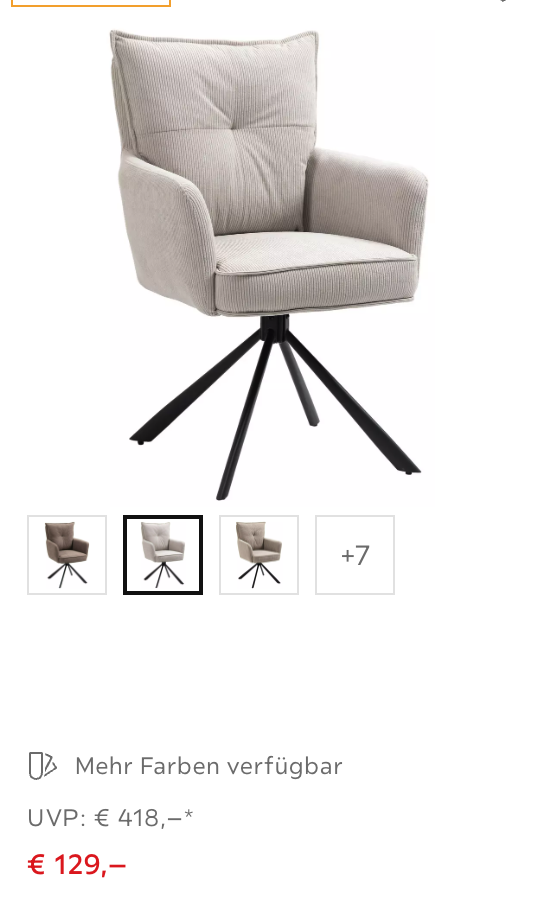

We further scrape for product details to add as textual conditioning tokens for training:

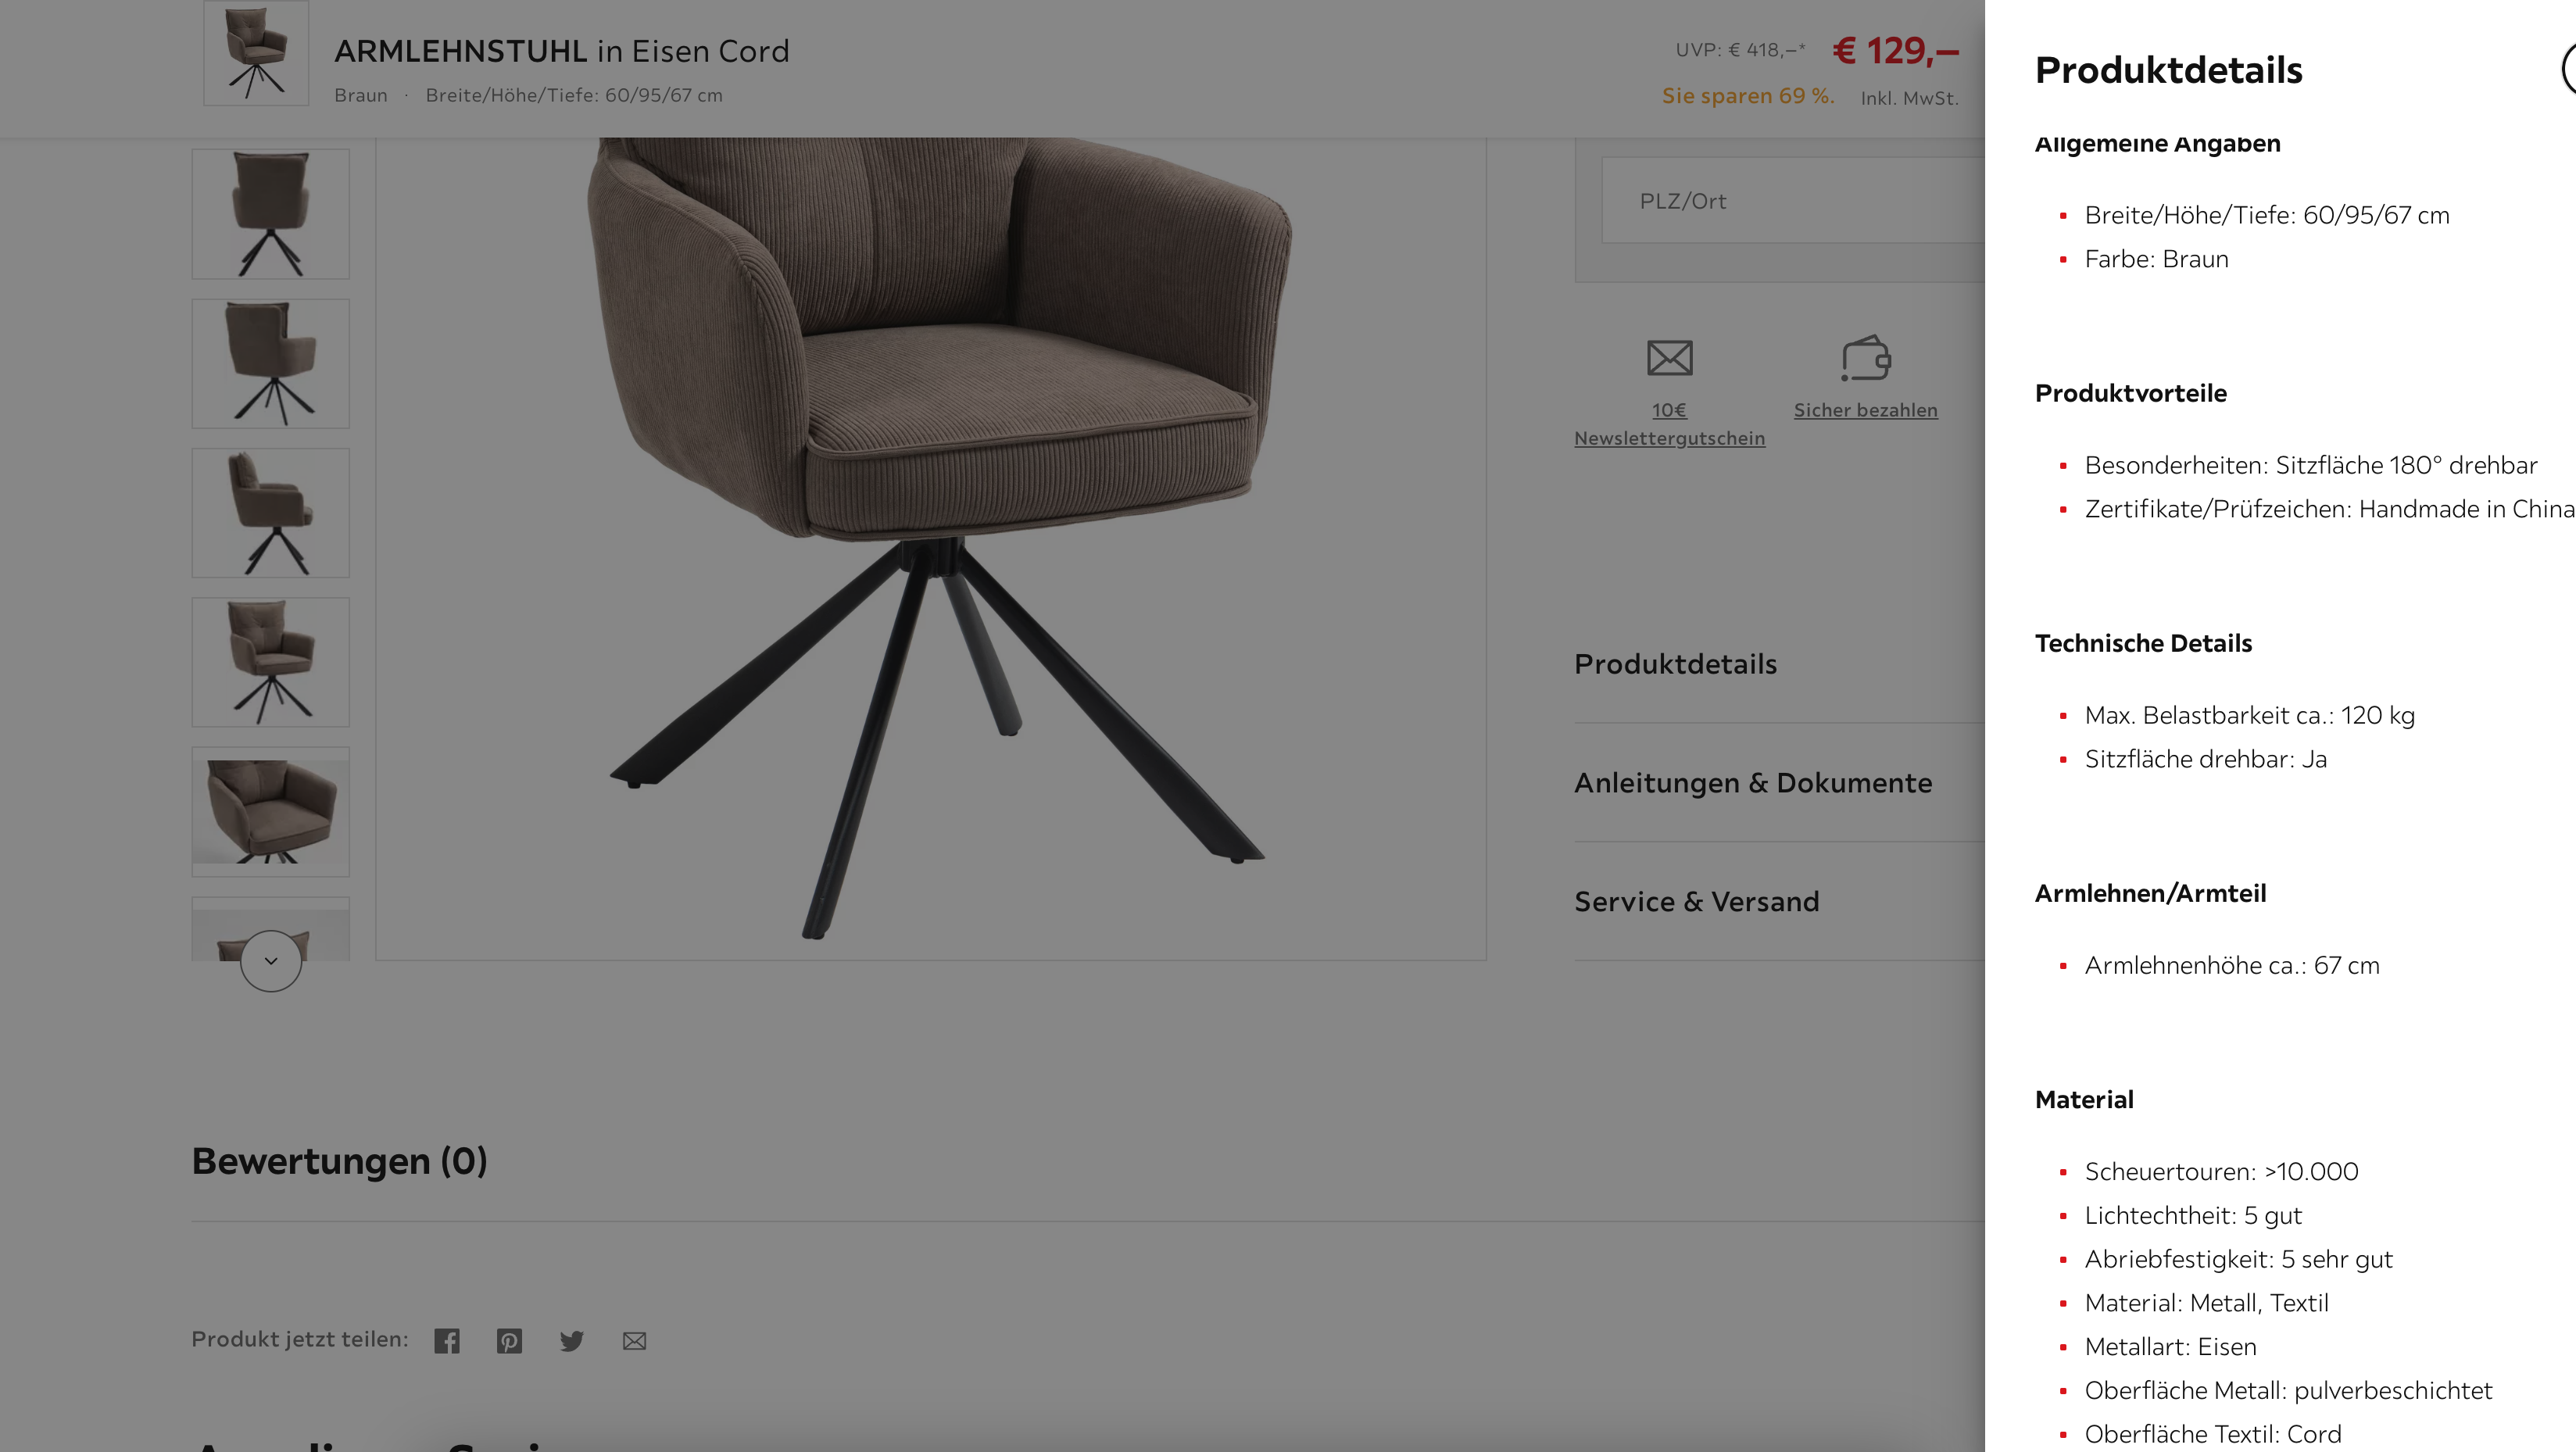

Further we can scrape the price which we later bin into "#cheap #affordable #expensive". There is also the option to rate a product. However, ratings are only sparsely available such that we ignore them.


## Crawling

In [95]:
import os
import urllib.request
import uuid
import time
from playwright.sync_api import Playwright, sync_playwright
import datetime

class XXXLutzSpider:
    def __init__(self):
        self.start_url = 'https://www.xxxlutz.de/stuehle-C12C1'
        self.image_directory = 'images'
        os.makedirs(self.image_directory, exist_ok=True)
        self.image_count = 0

    def download_image(self, image_url, filename):
        """
        Downloads the image from the given URL and saves it to the specified
        file. Returns True if the operation is successful, False otherwise.
        """
        try:
            urllib.request.urlretrieve(image_url, filename)
            return True
        except urllib.error.HTTPError as e:
            # If the server returns a 403 Forbidden error, try to bypass it using
            # one of several strategies
            if e.code == 403:
                # Option 1: Set a custom User-Agent header
                headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
                opener = urllib.request.build_opener()
                opener.addheaders = headers.items()
                urllib.request.install_opener(opener)
                urllib.request.urlretrieve(image_url, filename)
                return True

            # If none of the strategies work, log the error and return False
            print(f'Error downloading image: {e}')
            return False
            
    def get_save_csv_set(self, a=None):
        # if a is not None, save set a to csv file
        if a is not None:
            with open('xxxlutz.csv', 'w') as f:
                for item in a:
                    f.write("%s\n" % item)
        # read csv file and return set
        with open('xxxlutz.csv', 'r') as f:
            a = set()
            for line in f:
                a.add(line.strip())
        
        return a
    
   
    
    def download_images_of_parent(self, parent, filename_prefix):
        for i, image_url_element in enumerate(parent.query_selector_all('img[srcset]')):
            # image_url = image_url_element.get_attribute('srcset').strip()
            image_url = image_url_element.get_attribute('src').strip()
            filename = f'{filename_prefix}_{i+1}.jpg'
            if image_url not in self.a:
                self.a.add(image_url)
                self.get_save_csv_set(self.a)
                success = self.download_image(image_url, os.path.join(self.image_directory, filename))
                if success:
                    self.image_count += 1
                
                print(f'Download {image_url}')


    def run(self):
        with sync_playwright() as p:
            browser = p.firefox.launch(headless=True)
            context = browser.new_context()
            page = context.new_page()
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
            page.set_extra_http_headers(headers)
            page.goto(self.start_url)
            page.wait_for_selector('button[data-purpose="cookieBar.button.accept"]').click()
            self.a = self.get_save_csv_set()
            last_pos = 0

            with open('urls.csv', 'w') as f:
                f.write('url,uuid,price\n')
            url_file = open('urls.csv', 'a')

            while True:
                product_elements = page.query_selector_all('article')

                for i, product in enumerate(product_elements[last_pos:]):
                    last_pos+=1
                    price_parent = product.query_selector('div[data-testid="productCard.preview"]')
                    parent_more_options = product.query_selector('div > ul')
                    # parents.append(paren1)
                    product_url = 'https://www.xxxlutz.de'+product.query_selector("a").get_attribute('href')


                    # page.goto(product_url)
                    # page.click('text=Produktdetails')
                    # # sidebar_section = page.query_selector('section[data-purpose="modal.body"]')
                    # # get immediate child ul of sidebar section
                    # # modal_sidebar = sidebar_section.query_selector('ul')
                    # modal_sidebar_lis = page.query_selector_all('section[data-purpose="modal.body"]>ul>li')
                    # all_tags = ''
                    # for li in modal_sidebar_lis:
                    #     heading = li.query_selector('div').inner_text()
                    #     tags = ['||'+heading+'||'+x.inner_text() for x in li.query_selector_all('li')]
                    #     all_tags += '&&&'.join(tags)
                    
                    

                    # get all text from modal sidebar
                    # tags = modal_sidebar.inner_text().replace('\n', ' ').strip()
                    


                    unique_uuid = uuid.uuid5(uuid.NAMESPACE_URL, product_url)

                    
                    price=None
                    if price_parent:
                       
                        # image_url = image_urls[len(image_urls)//2].get_attribute('src').strip()
                        price_element = product.query_selector('div[data-purpose="product.price.current"]')
                        if price_element:
                            price = price_element.inner_text().replace('€', '').replace(',', '.').replace('\u202f', '').strip()
                            if not price:
                                price = product.query_selector('sup').inner_text()

                            # unique_url = price_parent.query_selector_all('img[srcset]')[0].get_attribute('src').strip()
                            
                            # generate unique uuid from unique url
                            # unique_uuid = uuid.uuid5(uuid.NAMESPACE_URL, unique_url)
                            filename_prefix = f'{unique_uuid}_{price}'
                            
                            self.download_images_of_parent(price_parent, filename_prefix)
                            if parent_more_options:
                                self.download_images_of_parent(parent_more_options, filename_prefix)

                    if price is None:
                        price = ''
                    url_file.write(f'{product_url},{unique_uuid},{price}\n')
                    url_file.flush()             

                # Click the "Load more" button to load the next page of products
              
                load_more_button = page.query_selector('button[data-purpose="listing.loadMore.next.button"]')
                if not load_more_button:
                    break
                load_more_button.click()
                time.sleep(3) # wait for 1 second before scraping the new data

            browser.close()

        print(f'Scraped {self.image_count} images.')
      


    def run_get_tags(self):
        with sync_playwright() as p:
            browser = p.firefox.launch(headless=True)
            context = browser.new_context()
            page = context.new_page()
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
            page.set_extra_http_headers(headers)
            page.goto(self.start_url)
            page.wait_for_selector('button[data-purpose="cookieBar.button.accept"]').click()

            with open('tags.csv', 'w') as f:
                f.write('url,uuid,tags\n')
            tags_file = open('tags.csv', 'a')
            # read url file
            with open('urls.csv', 'r') as f:
                url_data = f.readlines()
            urls = [x.split(',')[0] for x in url_data]
            urls = urls[1:]
            urls = list(set(urls))
            unique_uuids = [uuid.uuid5(uuid.NAMESPACE_URL, x) for x in urls]
            for i, (id, url) in enumerate(zip(unique_uuids, urls)):
                page.goto(url)
                page.click('text=Produktdetails')
                 # sidebar_section = page.query_selector('section[data-purpose="modal.body"]')
                # get immediate child ul of sidebar section
                # modal_sidebar = sidebar_section.query_selector('ul')
                modal_sidebar_lis = page.query_selector_all('section[data-purpose="modal.body"]>ul>li')
                all_tags = ''
                for li in modal_sidebar_lis:
                    heading = li.query_selector('div').inner_text()
                    tags = ['||'+heading+'||'+x.inner_text() for x in li.query_selector_all('li')]
                    all_tags += '&&&'.join(tags)

                tags_file.write(f'{url},{id},{all_tags}\n')
                tags_file.flush()
         
            browser.close()

        print(f'Scraped {self.image_count} images.')

if __name__ == '__main__':
    spider = XXXLutzSpider()
    spider.run()
    spider.run_get_tags()

ModuleNotFoundError: No module named 'playwright'

## Training data preparation
### Filtering Images


In [ ]:
# import os
# from PIL import Image
# from tqdm import tqdm

# if not os.path.exists('images_resized2'):
#     os.makedirs('images_resized2')

# for image in tqdm(os.listdir('images'), desc='Resizing Images'):
#     img_path = os.path.join('images', image)
#     img = Image.open(img_path)
#     aspect_ratio = img.width / img.height
#     new_height = int(128 / aspect_ratio)
#     resized_img = img.resize((128, new_height))
#     resized_img.save(os.path.join('images_resized2', image))


Resizing Images: 100%|██████████| 10508/10508 [13:52<00:00, 12.62it/s]


In [ ]:
image_groups = {}
for image in os.listdir('images'):
    parts = image.split('_')
    if len(parts) > 1:
        base_name = '_'.join(parts[:-1])
        if base_name not in image_groups:
            image_groups[base_name] = []
        image_groups[base_name].append(image)

for base_name, group in image_groups.items():
    group.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

import mlx.core as mx
from mlx_vlm import load, generate

model_path = "mlx-community/llava-phi-3-mini-4bit"
# model_path = 'mlx-community/nanoLLaVA'
model, processor = load(model_path)


def count_chairs_in_image(image_path):
    prompt = processor.tokenizer.apply_chat_template(
        [{"role": "user", "content": f"<image>\nPrecisely count the number of chairs. Answer only with the literal number"}],
        tokenize=False,
        add_generation_prompt=True,
    )

    output = generate(model, processor, image_path, prompt)
    
    return int(output.strip())


from tqdm import tqdm
if not os.path.exists('images_filtered'):
    os.makedirs('images_filtered')
for base_name, group in tqdm(image_groups.items(), desc='Filtering Images'):

    if os.path.exists(f'images_filtered/{group[0]}'):
        continue

    try:
        chair_count = count_chairs_in_image(f'images/{group[0]}')
        if chair_count > 1:
            continue 
        
        if len(group) > 1:
            chair_count = count_chairs_in_image(f'images/{group[1]}')
            if chair_count > 1:
                continue 
    
        for image in group:
            os.system(f'cp images/{image} images_filtered/{image}')

    except Exception as e: 
        print(e)
        continue



Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Filtering Images: 100%|██████████| 5328/5328 [4:10:45<00:00,  2.82s/it]  


Although the llava phi3 model is only 3 billion parameters it performs better than the llava1.6/ llava-next model (7b) on this simple counting task. Paligemma (Google) is too slow.

Automatic and following manual filtering  reduces the images from 10500 to 6500

### Resizing and padding

In [ ]:
# resize images to 512x512, fill white aspact ratio
# adapted from https://stackoverflow.com/a/44371790/9549296

import cv2
import os
from PIL import Image
import numpy as np

images = os.listdir('images_filtered')
os.makedirs('images_resized2', exist_ok=True)
for image in tqdm(images):
    if os.path.exists(f'images_resized2/{image}'):
        continue
    try:
        img = cv2.imread(f'images/{image}')
        h, w, _ = img.shape
        if h > w:
            new_img = cv2.resize(img, (512, int(512*h/w)))
        else:
            new_img = cv2.resize(img, (int(512*w/h), 512))

        if h > w:
            new_img = np.ones((h, h, 3), dtype=np.uint8) * 255
            new_img[:, (h-w)//2:(h-w)//2+w] = img
        else:
            new_img = np.ones((w, w, 3), dtype=np.uint8) * 255
            new_img[(w-h)//2:(w-h)//2+h, :] = img
        
        new_img = cv2.resize(new_img, (512, 512))
        
        cv2.imwrite(f'images_resized2/{image}', new_img)
    except Exception as e:
        # print(e)
        continue

100%|██████████| 6358/6358 [00:00<00:00, 79152.61it/s]


### Preparing tags

The tags are scraped from the site as mentioned above. As such it will be interesting to see how well the model handles german tag-words.

In [ ]:
import pandas as pd 
tags = pd.read_csv('tags.csv')
tags.iloc[0]

url     https://www.xxxlutz.de/p/joop-stuhl-echtleder-...
uuid                 78cb1984-7eed-5efc-aeb1-998c5fc441ec
tags    ||Allgemeine Angaben||Breite/Höhe/Tiefe: 53/86...
Name: 0, dtype: object

In [ ]:

def process_tags(s):
    tag_string = '||'.join(s.split('&&&')).replace('||||','||').replace(' ca.','').replace('ca.','').replace(' cm','cm').replace(' kg','kg').replace('°','grad').replace(':','')
    new_tag_string = ''
    new_tag_string = ''
    for i in range(len(tag_string)):
        if i > 0 and i < len(tag_string) - 1 and tag_string[i-1].isdigit() and tag_string[i+1].isdigit():
            new_tag_string += tag_string[i].replace(',', '.') 
        else:
            new_tag_string += tag_string[i] + ''
    tag_string = new_tag_string.strip()

    tag_split = tag_string.split('||') 
    tag_split = [x for x in tag_split if x]

    actual_tags = []
    for i in range(0, len(tag_split), 2):
        
        try:
            actual_tag = tag_split[i+1]
        except:
            actual_tags.append(tag_split[i])
            continue

        if 'Breite/Höhe/Tiefe' in actual_tag:
            sizes = actual_tag.split(' ')[-1].split('/')
            if 'cm' in sizes[-1]:
                scale = 'cm'
            elif 'mm' in sizes[-1]:
                scale = 'mm'
            elif 'm' in sizes[-1]:
                scale = 'm'
            actual_tags.append(tag_split[i]+' '+'Breite: '+sizes[0]+scale)
            actual_tags.append(tag_split[i]+' '+'Höhe: '+sizes[1]+scale)
            actual_tags.append(tag_split[i]+' '+'Tiefe: '+sizes[2])
        elif '(Länge/Breite/Höhe)' in actual_tag and 'Paket 1' in actual_tag:
            sizes = actual_tag.split(' (Länge/Breite/Höhe)')[-2].split(' ')[-1].split('/')
            if 'cm' in sizes[-1]:
                scale = 'cm'
            elif 'mm' in sizes[-1]:
                scale = 'mm'
            elif 'm' in sizes[-1]:
                scale = 'm'
            actual_tags.append(tag_split[i]+' '+'Paket 1 Länge: '+sizes[0]+scale)
            actual_tags.append(tag_split[i]+' '+'Paket 1 Breite: '+sizes[1]+scale)
            actual_tags.append(tag_split[i]+' '+'Paket 1 Höhe: '+sizes[2])
        elif 'Paket 2' in actual_tag and '(Länge/Breite/Höhe)' in actual_tag:
            sizes = actual_tag.split(' (Länge/Breite/Höhe)')[-2].split(' ')[-1].split('/')
            if 'cm' in sizes[-1]:
                scale = 'cm'
            elif 'mm' in sizes[-1]:
                scale = 'mm'
            elif 'm' in sizes[-1]:
                scale = 'm'
            actual_tags.append(tag_split[i]+' '+'Paket 2 Länge: '+sizes[0]+scale)
            actual_tags.append(tag_split[i]+' '+'Paket 2 Breite: '+sizes[1]+scale)
            actual_tags.append(tag_split[i]+' '+'Paket 2 Höhe: '+sizes[2])
        elif 'Paket 3' in actual_tag and '(Länge/Breite/Höhe)' in actual_tag:
            sizes = actual_tag.split(' (Länge/Breite/Höhe)')[-2].split(' ')[-1].split('/')
            if 'cm' in sizes[-1]:
                scale = 'cm'
            elif 'mm' in sizes[-1]:
                scale = 'mm'
            elif 'm' in sizes[-1]:
                scale = 'm'
            actual_tags.append(tag_split[i]+' '+'Paket 3 Länge: '+sizes[0]+scale)
            actual_tags.append(tag_split[i]+' '+'Paket 3 Breite: '+sizes[1]+scale)
            actual_tags.append(tag_split[i]+' '+'Paket 3 Höhe: '+sizes[2])
        elif 'Farbe' in actual_tag:
            for tag in actual_tag.split(','):
                actual_tags.append(tag_split[i]+' Farbe '+tag.replace('Farbe',''))
        else:
            for tag in actual_tag.split(','):
                actual_tags.append(tag_split[i]+' '+tag)

    actual_tags
    # remove a word if it repeats like : "Material Material"
    actual_tags_no_word_repeat = []
    for tag in actual_tags:
        new_tag = ''
        last_word = ''
        for word in tag.split():
            if word != last_word:
                new_tag += word + ' '
                last_word = word
        actual_tags_no_word_repeat.append(new_tag.strip())

    return actual_tags_no_word_repeat
        
process_tags(tags.iloc[3000]['tags'])

['Allgemeine Angaben Breite: 67cm',
 'Allgemeine Angaben Höhe: 85cm',
 'Allgemeine Angaben Tiefe: 60cm',
 'Allgemeine Angaben Farbe Schwarz',
 'Allgemeine Angaben Farbe Mokka',
 'Allgemeine Angaben Kollektionsname TAMINA',
 'Produktvorteile Besonderheiten Lederauswahl',
 'Produktvorteile Stoffauswahl',
 'Produktvorteile Typenauswahl',
 'Produktvorteile inklusive Armlehnen',
 'Produktvorteile Gestellauswahl',
 'Technische Details Max. Belastbarkeit 140kg',
 'Armlehnen/Armteil Armlehnenhöhe 68cm',
 'Material Scheuertouren 30.000',
 'Material Lichtechtheit 4 ziemlich gut',
 'Material Abriebfestigkeit 4 gut',
 'Material Pillingbildung 4 leicht',
 'Material Textil',
 'Material Oberfläche Textil Mikrofaser',
 'Material Materialzusammensetzung 100 % Polyester',
 'Beine Metallart Eisen',
 'Beine Oberfläche Metall lackiert',
 'Beine Farbe Schwarz',
 'Beine Anzahl der Beine 4',
 'Beine Beinform eckig',
 'Beine Flachrohr',
 'Beine Material Metall',
 'Sitzfläche Sitzbreite 62cm',
 'Sitzfläche Sitz

In [ ]:
len(tags) - tags['uuid'].unique().shape[0]

0

In [ ]:
from tqdm.auto import tqdm 
import os
import unicodedata
import re

def replace_unicode_with_ascii(text):
    """
    Replace Unicode characters in the given text with their ASCII equivalents.
    If an ASCII equivalent is not available, the character is removed.
    """
    normalized_text = unicodedata.normalize('NFKD', text)
    ascii_bytes = normalized_text.encode('ascii', 'ignore')
    ascii_text = ascii_bytes.decode('ascii')
    
    return ascii_text



max_len = 0
tags_dict = {}
mean_len = 0 
counter = 0
for i, row in tags.iterrows():
    if pd.isna(row['tags']):
        continue
    curr_len = len(' '.join(process_tags(row['tags'])).split(' '))
    if curr_len > max_len:
        max_len = curr_len
    mean_len += curr_len
    counter += 1
    the_tags = process_tags(row['tags']) 
    while curr_len > 219: # maximum clip length (its 225) - start and end token, make 4 less to make sure it fits (lenght is actually 75, and clip is called 3 times, results are concatenated, so 75*3=225)
    # remove last tags of the chairs as they are usually not the most important (e.g. Shipping dimensions of packages (info is already given in the dimensions of the chair))
        the_tags = the_tags[:-1]
        curr_len = len(' '.join(the_tags).split(' '))

    tags_dict[row['uuid']] = ', '.join(the_tags)

print('max_len:', max_len)
print('mean_len:', mean_len/counter)
os.makedirs('images_tags_final', exist_ok=True)
counter = 0
for img in tqdm(os.listdir('images_filtered')[:256]):
    img_old = img
    uuid = img.split('_')[0]
    if uuid in tags_dict:
        counter+=1
        img = img.replace('‒','')
        with open(f'images_tags_final/{img.replace(".jpg","")}.txt', 'w') as file:
            mytags = tags_dict[uuid] 
            price_string = img.split('_')[-2].replace('.‒','.00') 
            if price_string.count('.') > 1:
                price_string = price_string.replace('.', '', 1)
                
            price = str(int(round(float(price_string))))
            mytags = f'Preis {price}, {mytags}'.replace('Ä', 'Ae').replace('ä', 'ae').replace('Ö', 'Oe').replace('ö', 'oe').replace('Ü', 'Ue').replace('ü', 'ue').replace('ß', 'ss')
            mytags = replace_unicode_with_ascii(mytags)
            file.write(mytags)
        # copy image to new folder
        
        os.system(f'cp images_filtered/{img_old} images_tags_final/{img}')
counter

import os

folder_path = 'images_tags_final'
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_path, file_name)
        text = open(file_path, 'r').read()
        text = replace_unicode_with_ascii(text)
        with open(file_path, 'w') as file:
            file.write(text)
        


max_len: 271
mean_len: 100.12443194113828


100%|██████████| 256/256 [00:00<00:00, 395.72it/s]


In [ ]:
import os 

image_dir = './images_tags_final'


metadata_file = 'C:\piyo\piyo_md.json'
resolution = 512
batch_size = 2
epochs = 5
max_bucket_reso = 512
use_mixed_precision = 'fp16'
lr = 5e-6
train_steps = 10000
flip_aug = True
toml = f"""[general]
shuffle_caption = true
caption_extension = '.txt'
keep_tokens = 1

[[datasets]]
resolution = [{resolution}, {resolution}]
batch_size = {batch_size}
enable_bucket= true
# max_bucket_reso = 1024
# min_bucket_reso = 128
# bucket_reso_steps = 64

    [[datasets.subsets]]
    image_dir = '{image_dir}'
    metadata_file = '{image_dir}'
    keep_tokens = 1
    flip_aug = true
    num_repeats = {epochs}
    

"""
# check if image_dir exists
if not os.path.exists(image_dir):
    raise Exception(f"Image directory {image_dir} does not exist")
# make it full path
image_dir = os.path.abspath(image_dir)

with open('dataset_config.toml', 'w') as f:
    f.write(toml)

dataset_toml = os.path.abspath('dataset_config.toml')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/amos/Programming/Studium/AIML/Chairs/images_tags_final/fff852e4-140f-53d4-a9be-7f4c6558abf0_149.90_2.jpg'

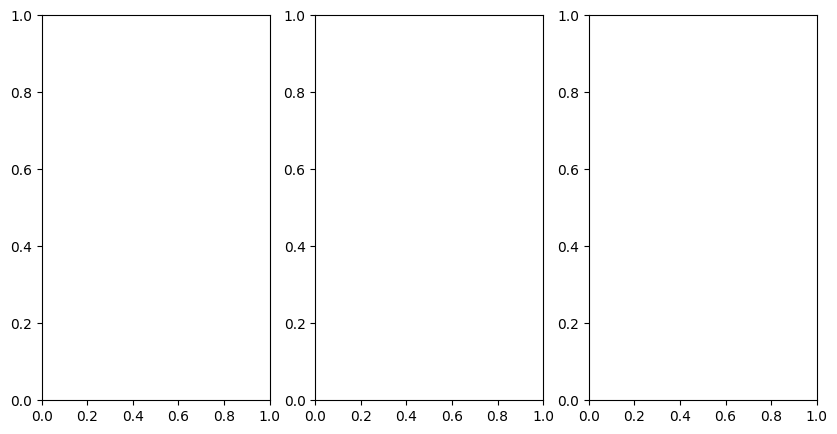

In [ ]:
# Sample prompts
# 1 von fff852e4-140f-53d4-a9be-7f4c6558abf0.jpg
# 2 von fa257c34-6d93-5f57-9b2c-579d8b59890f.jpg
training_sample_prompts = """
Preis 150, Allgemeine Angaben Breite: 66cm, Allgemeine Angaben Hoehe: 98cm, Allgemeine Angaben Tiefe: 66cm, Allgemeine Angaben Gewicht 11kg, Allgemeine Angaben Farbe Dunkelgrau, Technische Details Max. Belastbarkeit 136kg, Produktmerkmale Rueckenlehne Hoehe 49cm, Armlehnen/Armteil Armlehnenhoehe 18cm, Bezug Material Textil, Material Textil, Material Oberflaeche Textil Textilgeflecht, Kundenhinweise Pflegehinweise Keine scharfen Reinigungsmittel verwenden --w 512 --h 512 --d 1 --l 7.5 --s 28

Preis 370, Allgemeine Angaben Breite: 56cm, Allgemeine Angaben Hoehe: 86cm, Allgemeine Angaben Tiefe: 59cm, Allgemeine Angaben Gewicht 15kg, Allgemeine Angaben Farbe Braun, Artikel besteht aus Anzahl der Stuehle 2, Technische Details Anzahl der Sitzplaetze 1, Produktmerkmale Bezug Stoffzusammensetzung 100% Polyester, Material Holzwerkstoff --w 512 --h 512 --d 1 --l 7.5 --s 28

Preis 499, Allgemeine Angaben Breite: 62cm, Allgemeine Angaben Hoehe: 90cm, Allgemeine Angaben Tiefe: 65cm, Allgemeine Angaben Farbe Haselnussfarben, Allgemeine Angaben Farbe Cognac, Allgemeine Angaben Farbe Wildeiche, Produktvorteile Zubehoer inklusive Armlehnen, Produktvorteile Gestell, Produktvorteile Besonderheiten Lederauswahl, Produktvorteile Stoffauswahl, Produktvorteile Typenauswahl, Produktvorteile inklusive Armlehnen, Produktvorteile Gestellauswahl, Artikel besteht aus Anzahl der Rueckenkissen 1, Artikel besteht aus Rueckenkissen, Technische Details Max. Belastbarkeit 140kg, Armlehnen/Armteil Armlehnenhoehe 66cm, Material Oberflaeche geoelt, Material Lederart Kombination Echtleder/Stoff, Material Lederqualitaet Rindleder, Material Holzart Eiche, Material Holzqualitaet Echtholz, Material Echtholz massiv, Material Scheuertouren 50.000, Material Oberflaeche Leder pigmentiert, Material Lichtechtheit 5 gut, Material Abriebfestigkeit 4 gut, Material Pillingbildung 4 leicht, Material Holz, Material Textil, Material Leder, Material Oberflaeche Textil Webstoff, Material Materialzusammensetzung 100 % Polyester, Beine Farbe Eiche Bianco, Beine Anzahl der Beine 4, Beine Beinform konisch, Beine Stativgestell, Sitzflaeche Sitzbreite 42-47cm, Sitzflaeche Sitzhoehe 48cm, Sitzflaeche Sitztiefe 42cm, Innenleben Rueckenlehne Schaumstoff, Innenleben Schaumstoff, Kundenhinweise Verwendung Indoor, Kundenhinweise Lieferhinweis fuer Endkunden zerlegt, Kundenhinweise Jedes Echtholzprodukt ist ein Unikat. Woelbungen, Kundenhinweise Farbverlaeufe etc. sind warentypisch und stellen keinen Reklamationsgrund dar., Kundenhinweise Transporthinweis fuer Endkunden Kombi, Kundenhinweise Montagehinweis fuer Endkunden handwerkliche Begabung, Kundenhinweise Pflegehinweise Holzpflegemittel verwenden, Kundenhinweise Lederpflegemittel verwenden, Kundenhinweise nebelfeucht wischen, Verpackungsmasse Anzahl der Pakete 2, Verpackungsmasse Paket 1 Laenge: 65cm, Verpackungsmasse Paket 1 Breite: 65cm, Verpackungsmasse Paket 1 Hoehe: 76cm, Verpackungsmasse Paket 2 Laenge: 56cm, Verpackungsmasse Paket 2 Breite: 51cm --w 512 --h 512 --d 1 --l 7.5 --s 28
"""
# d is random seed, l classifier free guidance, s number of steps

# display images
from PIL import Image
import matplotlib.pyplot as plt

image_paths = [
    'images_tags_final/fff852e4-140f-53d4-a9be-7f4c6558abf0_149.90_2.jpg',
    'images_tags_final/fa257c34-6d93-5f57-9b2c-579d8b59890f_369.95_2.jpg',
    'images_tags_final/de28ad4c-0927-5ebd-b31c-2636420ac44a_499._1.jpg'
]

fig, axs = plt.subplots(1, len(image_paths), figsize=(10, 5))

for i, path in enumerate(image_paths):
    img = Image.open(path)
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()


### Prepare kohya sd-script specific setup


In [ ]:
import torch 
import os 

!git clone https://github.com/kohya-ss/sd-scripts
# if mps is available, install those requirements
if torch.backends.mps.is_available():
    print('Macbook installation')
    !git clone --recursive https://github.com/bmaltais/kohya_ss
    os.chdir('kohya_ss')
    !pip install xformers bitsandbytes==0.41.1
    !pip install tensorflow-macos tensorflow-metal tensorboard==2.14.1
    !pip install onnxruntime==1.17.1
    !pip install -r requirements.txt
    os.chdir('..')
    # fix for xformers macos https://github.com/bmaltais/kohya_ss/issues/2071
    !ls /Users/amos/miniconda3/envs/sd-scripts/lib/python3.10/site-packages
    !rm -r /Users/amos/miniconda3/envs/sd-scripts/lib/python3.10/site-packages/xformers
    !rm -r /Users/amos/miniconda3/envs/sd-scripts/lib/python3.10/site-packages/xformers-0.0.26.post1.dist-info
else: 
    
    os.chdir('sd-scripts')
    !pip install -r requirements.txt
    os.chdir('..')

fatal: destination path 'sd-scripts' already exists and is not an empty directory.
Macbook installation
fatal: destination path 'kohya_ss' already exists and is not an empty directory.
  Using cached xformers-0.0.26.post1-cp310-cp310-macosx_11_0_arm64.whl
Obtaining file:///Users/amos/Programming/Studium/AIML/Chairs/kohya_ss/sd-scripts (from -r requirements.txt (line 35))
  Preparing metadata (setup.py) ... done
  Using cached torch-2.0.0-cp310-none-macosx_11_0_arm64.whl.metadata (23 kB)
Using cached torch-2.0.0-cp310-none-macosx_11_0_arm64.whl (55.8 MB)
  Attempting uninstall: library
    Found existing installation: library 0.0.0
    Uninstalling library-0.0.0:
      Successfully uninstalled library-0.0.0
  Running setup.py develop for library
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2
    Uninstalling torch-2.1.2:
      Successfully uninstalled torch-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

In [ ]:
# change directory to the sd-scripts folder
os.chdir('sd-scripts')
# make training_metadata_tags.json file 
!
command = f"python finetune/merge_dd_tags_to_metadata.py --full_path {image_dir} meta_cap.json"
os.system(command)

!python finetune/clean_captions_and_tags.py meta_cap.json meta_cap_clean.json
os.chdir('..')

metadata_file_path = os.path.abspath('sd-scripts/meta_cap_clean.json')

2024-06-12 15:36:07 INFO     found 209 images.   ]8;id=951395;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/merge_dd_tags_to_metadata.py\merge_dd_tags_to_metadata.py]8;;\:]8;id=225968;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/merge_dd_tags_to_metadata.py#23\23]8;;\
                    INFO     new metadata will   ]8;id=276783;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/merge_dd_tags_to_metadata.py\merge_dd_tags_to_metadata.py]8;;\:]8;id=515580;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/merge_dd_tags_to_metadata.py#33\33]8;;\
                             be created /                                       
                             新しいメタデータフ                                 
                             ァイルが作成されま                                 
                             す                                                 
                    INFO     merge tags

2024-06-12 15:36:09 INFO     loading existing     ]8;id=899826;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/clean_captions_and_tags.py\clean_captions_and_tags.py]8;;\:]8;id=969237;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/clean_captions_and_tags.py#131\131]8;;\
                             metadata:                                          
                             meta_cap.json                                      
                    INFO     cleaning captions    ]8;id=375827;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/clean_captions_and_tags.py\clean_captions_and_tags.py]8;;\:]8;id=140159;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/clean_captions_and_tags.py#138\138]8;;\
                             and tags.                                          
  0%|                                                   | 0/209 [00:00<?, ?it/s]                    ERROR  

## Training
Only the UNet is finetuned by default, the text encoder is left as-is.
The base model used is https://huggingface.co/runwayml/stable-diffusion-v1-5.

In [ ]:
from huggingface_hub import hf_hub_download
import os
# import shutil

cache_dir = '.cache'
os.makedirs(cache_dir, exist_ok=True)

model = hf_hub_download(repo_id="runwayml/stable-diffusion-v1-5", filename="v1-5-pruned.safetensors" )
model_path = os.path.abspath(model)


v1-5-pruned.safetensors: 100%|██████████| 7.70G/7.70G [04:02<00:00, 31.7MB/s]


In [99]:
model_path = os.path.abspath('downloaded_models/v1-5-pruned.safetensors')

In [96]:
model_path

'/Users/amos/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9/v1-5-pruned.safetensors'

In [88]:
!pip install torch==2.1.2 # fix "torch has no attribute mps"

In [89]:
# precompute latents (using encoder of the default model)
metadata_file_path = os.path.abspath('sd-scripts/meta_cap_clean.json')

os.chdir('sd-scripts')
command = f'python finetune/prepare_buckets_latents.py --full_path {image_dir} {metadata_file_path} meta_cap_buckets.json "{model}" --batch_size {batch_size} --max_resolution {max_bucket_reso},{max_bucket_reso} --mixed_precision {use_mixed_precision} --max_data_loader_n_workers=4'
os.system(command)
os.chdir('..')
metadata_file_path = os.path.abspath('sd-scripts/meta_cap_buckets.json')

get_preferred_device() -> mps


2024-06-12 17:41:44 INFO     found 209 images.     ]8;id=410068;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/prepare_buckets_latents.py\prepare_buckets_latents.py]8;;\:]8;id=533416;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/prepare_buckets_latents.py#70\70]8;;\
                    INFO     loading existing      ]8;id=772282;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/prepare_buckets_latents.py\prepare_buckets_latents.py]8;;\:]8;id=316150;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/prepare_buckets_latents.py#73\73]8;;\
                             metadata:                                          
                             /Users/amos/Programmi                              
                             ng/Studium/AIML/Chair                              
                             s/sd-scripts/meta_cap                              
                            

get_preferred_device() -> mps
get_preferred_device() -> mps
get_preferred_device() -> mps
get_preferred_device() -> mps


100%|██████████| 209/209 [01:50<00:00,  1.90it/s]
2024-06-12 17:43:37 INFO     bucket 0 (320, 704): ]8;id=223103;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/prepare_buckets_latents.py\prepare_buckets_latents.py]8;;\:]8;id=990317;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/prepare_buckets_latents.py#194\194]8;;\
                             9                                                  
                    INFO     bucket 1 (384, 640): ]8;id=894131;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/prepare_buckets_latents.py\prepare_buckets_latents.py]8;;\:]8;id=796767;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/prepare_buckets_latents.py#194\194]8;;\
                             97                                                 
                    INFO     bucket 2 (448, 576): ]8;id=991098;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/finetune/pre

In [103]:
# this code is adapted from https://github.com/Linaqruf/kohya-trainer/blob/main/kohya-LoRA-finetuner.ipynb
import datetime
import toml
import os
import torch

%store -r

dataset_repeats = 4 #
output_dir = 'checkpoints'
resume_path = None
os.makedirs(output_dir, exist_ok=True)

output_filename = f"chair_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

enable_sample_prompt = True  # @param {type:"boolean"}
sampler = "ddim"  # @param ["ddim", "pndm", "lms", "euler", "euler_a", "heun", "dpm_2", "dpm_2_a", "dpmsolver","dpmsolver++", "dpmsingle", "k_lms", "k_euler", "k_euler_a", "k_dpm_2", "k_dpm_2_a"]
noise_offset = 0.0  # @param {type:"number"}
# max_train_steps = 10000  # @param {type:"number"}

train_batch_size = 1  # @param {type:"number"}
mixed_precision = "no"  # @param ["no","fp16","bf16"] {allow-input: false}
# save_state = False  # @param {type:"boolean"}
save_precision = "fp16"  # @param ["float", "fp16", "bf16"] {allow-input: false}
save_n_epoch_ratio = 1  # @param {type:"number"}
save_model_as = "ckpt"  # @param ["ckpt", "safetensors", "diffusers", "diffusers_safetensors"] {allow-input: false}
max_token_length = 225  # @param {type:"number"}
clip_skip = 2  # @param {type:"number"}
gradient_checkpointing = True  # @param {type:"boolean"}
gradient_accumulation_steps = 1  # @param {type:"number"}
seed = -1  # @param {type:"number"}
logging_dir = "fine_tune/logs"
prior_loss_weight = 1.0

# os.chdir(repo_dir)

# sample_str = f"""
#   masterpiece, best quality, 1girl, aqua eyes, baseball cap, blonde hair, closed mouth, earrings, green background, hat, hoop earrings, jewelry, looking at viewer, shirt, short hair, simple background, solo, upper body, yellow shirt \
#   --n lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry \
#   --w 512 \
#   --h 768 \
#   --l 7 \
#   --s 28
# """

config = {
    "model_arguments": {
        "v2": False,
        # "v_parameterization": v_parameterization if v2 and v_parameterization else False,
        "v_parameterization": False,
        "pretrained_model_name_or_path": model_path,
        # "vae": vae,
    },
    "optimizer_arguments": {
        # "min_snr_gamma": min_snr_gamma if not min_snr_gamma == -1 else None,
        "optimizer_type": 'AdamW8bit',
        "learning_rate": lr,
        # "max_grad_norm": 1.0,
        # "train_text_encoder": train_text_encoder,
        # "optimizer_args": eval(optimizer_args) if optimizer_args else None,
        # "lr_scheduler": lr_scheduler,
        # "lr_warmup_steps": lr_warmup_steps,
        # "lr_scheduler_num_cycles": lr_scheduler_num_cycles if lr_scheduler == "cosine_with_restarts" else None,
        # "lr_scheduler_power": lr_scheduler_power if lr_scheduler == "polynomial" else None,
    },
    "dataset_arguments": {
        "debug_dataset": False,
        "in_json": metadata_file_path,
        "train_data_dir": image_dir,
        "dataset_repeats": dataset_repeats,
        "shuffle_caption": True,
        # "keep_tokens": keep_tokens, # ?
        "resolution": f"{resolution},{resolution}",
        "caption_dropout_rate": 0,
        "caption_tag_dropout_rate": 0,
        "caption_dropout_every_n_epochs": 0,
        "color_aug": False,
        "face_crop_aug_range": None,
        "token_warmup_min": 1,
        "token_warmup_step": 0,
    },
    "training_arguments": {
        "output_dir": output_dir,
        "output_name": output_filename,
        "save_precision": save_precision,
        "save_every_n_epochs": None,
        "save_n_epoch_ratio": save_n_epoch_ratio,
        "save_last_n_epochs": None,
        # "save_state": save_state,
        "save_last_n_epochs_state": None,
        "resume": resume_path,
        "train_batch_size": train_batch_size,
        "max_token_length": 225,
        "mem_eff_attn": False,
        "xformers": True if not torch.backends.mps.is_available() else False,
        # "max_train_steps": max_train_steps, 
        "max_data_loader_n_workers": 8,
        "persistent_data_loader_workers": True,
        "seed": seed if seed > 0 else None,
        "gradient_checkpointing": gradient_checkpointing,
        "gradient_accumulation_steps": gradient_accumulation_steps,
        "mixed_precision": mixed_precision,
        # "clip_skip": clip_skip if not v2 else None,
        "logging_dir": logging_dir,
        "log_prefix": output_filename,
        "noise_offset": noise_offset if noise_offset > 0 else None,
    },
    "sample_prompt_arguments": {
        "sample_every_n_steps": 100 if enable_sample_prompt else 999999,
        "sample_every_n_epochs": None,
        "sample_sampler": sampler,
    },
    "saving_arguments": {
        "save_model_as": save_model_as
    },
}

config_path = os.path.abspath("config_file.toml")
prompt_path = os.path.abspath("sample_prompt.txt")

for key in config:
    if isinstance(config[key], dict):
        for sub_key in config[key]:
            if config[key][sub_key] == "":
                config[key][sub_key] = None
    elif config[key] == "":
        config[key] = None

config_str = toml.dumps(config)

def write_file(filename, contents):
    with open(filename, "w") as f:
        f.write(contents)

write_file(config_path, config_str)
write_file(prompt_path, training_sample_prompts)

print(config_str)

[model_arguments]
v2 = false
v_parameterization = false
pretrained_model_name_or_path = "/Users/amos/Programming/Studium/AIML/Chairs/downloaded_models/v1-5-pruned.safetensors"

[optimizer_arguments]
optimizer_type = "AdamW8bit"
learning_rate = 5e-6

[dataset_arguments]
debug_dataset = false
in_json = "/Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/meta_cap_buckets.json"
train_data_dir = "/Users/amos/Programming/Studium/AIML/Chairs/images_tags_final"
dataset_repeats = 4
shuffle_caption = true
resolution = "512,512"
caption_dropout_rate = 0
caption_tag_dropout_rate = 0
caption_dropout_every_n_epochs = 0
color_aug = false
token_warmup_min = 1
token_warmup_step = 0

[training_arguments]
output_dir = "checkpoints"
output_name = "chair_2024-06-12_18-02-25"
save_precision = "fp16"
save_n_epoch_ratio = 1
train_batch_size = 1
max_token_length = 225
mem_eff_attn = false
xformers = false
max_data_loader_n_workers = 8
persistent_data_loader_workers = true
gradient_checkpointing = true
grad

In [104]:
import datetime 

accelerate_config = 'accelerate_config.toml'
accelerate_config = os.path.abspath(accelerate_config)
from accelerate.utils import write_basic_config

if not os.path.exists(accelerate_config):
    write_basic_config(save_location=accelerate_config)

output_dir = 'checkpoints'
os.makedirs(output_dir, exist_ok=True)
output_filename = f"chair_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

os.chdir('sd-scripts')
command = f'''accelerate launch --config_file={accelerate_config} --num_cpu_threads_per_process=1 fine_tune.py --sample_prompts={prompt_path} --config_file={config_path}'''
os.system(command)
os.chdir('..')

2024-06-12 18:02:33 INFO     Loading settings from            ]8;id=662883;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/train_util.py\train_util.py]8;;\:]8;id=443868;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/train_util.py#3744\3744]8;;\
                             /Users/amos/Programming/Studium/                   
                             AIML/Chairs/config_file.toml...                    
                    INFO     /Users/amos/Programming/Studium/ ]8;id=517900;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/train_util.py\train_util.py]8;;\:]8;id=334502;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/train_util.py#3763\3763]8;;\
                             AIML/Chairs/config_file                            
2024-06-12 18:02:33 INFO     prepare tokenizer                ]8;id=801862;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/train_util.py\

accelerator device: cpu
loaaad /Users/amos/Programming/Studium/AIML/Chairs/downloaded_models/v1-5-pruned.safetensors
loaaad /Users/amos/Programming/Studium/AIML/Chairs/downloaded_models/v1-5-pruned.safetensors
path /Users/amos/Programming/Studium/AIML/Chairs/downloaded_models/v1-5-pruned.safetensors
is_safetensors True /Users/amos/Programming/Studium/AIML/Chairs/downloaded_models/v1-5-pruned.safetensors
path /Users/amos/Programming/Studium/AIML/Chairs/downloaded_models/v1-5-pruned.safetensors


                    INFO     UNet2DConditionModel: 64, 8,  ]8;id=237424;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/original_unet.py\original_unet.py]8;;\:]8;id=251962;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/original_unet.py#1387\1387]8;;\
                             768, False, False                                  
2024-06-12 18:02:43 INFO     loading u-net: <All keys matched ]8;id=237020;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/model_util.py\model_util.py]8;;\:]8;id=171569;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/model_util.py#1010\1010]8;;\
                             successfully>                                      
2024-06-12 18:02:44 INFO     loading vae: <All keys matched   ]8;id=592844;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/model_util.py\model_util.py]8;;\:]8;id=144701;file:///Users/amos/Programming/Studium/A

Disable Diffusers' xformers
prepare optimizer, data loader etc.
'NoneType' object has no attribute 'cadam32bit_grad_fp32'


2024-06-12 18:02:49 INFO     use 8-bit AdamW optimizer | {}   ]8;id=676609;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/train_util.py\train_util.py]8;;\:]8;id=504556;file:///Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/library/train_util.py#3889\3889]8;;\
steps:   0%|          | 0/1600 [00:00<?, ?it/s]

running training / 学習開始
  num examples / サンプル数: 836
  num batches per epoch / 1epochのバッチ数: 836
  num epochs / epoch数: 2
  batch size per device / バッチサイズ: 1
  total train batch size (with parallel & distributed & accumulation) / 総バッチサイズ（並列学習、勾配合計含む）: 1
  gradient accumulation steps / 勾配を合計するステップ数 = 1
  total optimization steps / 学習ステップ数: 1600

epoch 1/2


/Users/amos/miniconda3/envs/sd-scripts/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/amos/miniconda3/envs/sd-scripts/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Traceback (most recent call last):
  File "/Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/fine_tune.py", line 526, in <module>
    train(args)
  File "/Users/amos/Programming/Studium/AIML/Chairs/sd-scripts/fine_tune.py", line 392, in train
    optimizer.step()
  File "/Users/amos/miniconda3/envs/sd-scripts/lib/py

In [92]:
os.path.islink('/Users/amos/Programming/Studium/AIML/Chairs/.cache/models--runwayml--stable-diffusion-v1-5/snapshots/1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9/v1-5-pruned.safetensors')

True

In [93]:
name_or_path = '/Users/amos/Programming/Studium/AIML/Chairs/.cache/models--runwayml--stable-diffusion-v1-5/snapshots/1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9/v1-5-pruned.safetensors'
os.path.islink(name_or_path)
# name_or_path = os.path.realpath(name_or_path) if os.path.islink(name_or_path) else name_or_path
# load_stable_diffusion_format = os.path.isfile(name_or_path)  # determine SD or Diffusers
# name_or_path

True

In [94]:
# https://huggingface.co/lllyasviel/ControlNet
# https://civitai.com/models/4201/realistic-vision-v20